In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
from io import BytesIO
from torch import nn

In [2]:
df_ = pd.read_csv('/kaggle/input/fashion-product-images-small/styles.csv', nrows=5000)
df = df_.sample(3000)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,44776,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2010,Casual,Lotto Men Black Dolce Vita Shoes,44776.jpg
1,55098,Women,Personal Care,Skin,Face Moisturisers,Cream,Spring,2017,Casual,Ponds Gold Radiance Youthful Night Repair Mois...,55098.jpg
2,11145,Men,Apparel,Topwear,Shirts,Purple,Fall,2011,Casual,Indigo Nation Men Bling Purple Shirts,11145.jpg
3,51001,Women,Apparel,Innerwear,Bra,Skin,Summer,2018,Casual,Enamor Full Figure Skin Bra,51001.jpg
4,26360,Women,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Arrow Woman Grey T-shirt,26360.jpg
5,48743,Men,Accessories,Jewellery,Bangle,Steel,Summer,2012,Casual,Revv Men Steel Bangle,48743.jpg
6,57154,Women,Apparel,Topwear,Tshirts,Grey Melange,Summer,2012,Casual,Elle Women Grey Melange T-shirt,57154.jpg
7,12591,Unisex,Apparel,Topwear,Tshirts,Blue,Fall,2011,Casual,Tantra Unisex Printed Blue Tshirts,12591.jpg
8,55038,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017,NaN,Lakme Absolute Matte Brick Lipstick 51,55038.jpg
9,25314,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Casio Youth Series Men Digital Watch AE-1100W-...,25314.jpg


In [3]:
df['tags'] = 'MasterCategory:'+'\''+df['masterCategory']+'\''+','+'SubCategory:'+'\''+df['subCategory']+'\''+','+'ArticleType:'+'\''+df['articleType']+'\''+','+'Colour:'+'\''+df['baseColour']+'\''+','+'Season:'+'\''+df['season']+'\''+','+'Usage:'+'\''+df['usage']+'\''+','+'Description:'+'\''+df['productDisplayName']+'\''

In [4]:
df['tags'] = df['tags'].astype(str)

In [5]:
def string_to_list(string):
    return string.split(',')

# Apply the function to convert each element in the column into a list
df['tags'] = df['tags'].apply(lambda x: string_to_list(x))

In [6]:
df['tags'].iloc[0][0]

"MasterCategory:'Footwear'"

In [7]:
df['tags'] = df['tags'].apply(lambda x:" ".join(x))

In [8]:
df['tags']

0       MasterCategory:'Footwear' SubCategory:'Shoes' ...
1       MasterCategory:'Personal Care' SubCategory:'Sk...
2       MasterCategory:'Apparel' SubCategory:'Topwear'...
3       MasterCategory:'Apparel' SubCategory:'Innerwea...
4       MasterCategory:'Apparel' SubCategory:'Topwear'...
                              ...                        
2995    MasterCategory:'Apparel' SubCategory:'Topwear'...
2996    MasterCategory:'Apparel' SubCategory:'Topwear'...
2997    MasterCategory:'Apparel' SubCategory:'Topwear'...
2998    MasterCategory:'Accessories' SubCategory:'Bags...
2999    MasterCategory:'Apparel' SubCategory:'Topwear'...
Name: tags, Length: 3000, dtype: object

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model_name = "openai/clip-vit-base-patch32"
clip_text_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_image_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

for param in clip_text_model.parameters():
    param.requires_grad = False
for param in clip_image_model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2024-04-01 21:41:55.504636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 21:41:55.504760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 21:41:55.628604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [10]:
class AdditionalLayers(nn.Module):
    def __init__(self, input_size, output_size):
        super(AdditionalLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class projection_layer(nn.Module):
    def __init__(self):
        super(projection_layer, self).__init__()
    def forward(self, x):
        return x.pooler_output
        

In [11]:
text_feature_size = clip_text_model.text_projection.out_features
image_feature_size = clip_image_model.vision_model.config.hidden_size

output_size = 256
additional_text_layers = AdditionalLayers(text_feature_size, output_size)
additional_image_layers = AdditionalLayers(image_feature_size, output_size)

projection = projection_layer()

In [12]:
clip_text_model.text_projection = nn.Sequential(clip_text_model.text_projection, additional_text_layers).to(device)
clip_image_model.vision_model = nn.Sequential(clip_image_model.vision_model, projection, additional_image_layers).to(device)

In [13]:
text_descriptions = df['tags'].values
image_urls = df['image'].values

In [14]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,tags
0,44776,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2010,Casual,Lotto Men Black Dolce Vita Shoes,44776.jpg,MasterCategory:'Footwear' SubCategory:'Shoes' ...
1,55098,Women,Personal Care,Skin,Face Moisturisers,Cream,Spring,2017,Casual,Ponds Gold Radiance Youthful Night Repair Mois...,55098.jpg,MasterCategory:'Personal Care' SubCategory:'Sk...
2,11145,Men,Apparel,Topwear,Shirts,Purple,Fall,2011,Casual,Indigo Nation Men Bling Purple Shirts,11145.jpg,MasterCategory:'Apparel' SubCategory:'Topwear'...
3,51001,Women,Apparel,Innerwear,Bra,Skin,Summer,2018,Casual,Enamor Full Figure Skin Bra,51001.jpg,MasterCategory:'Apparel' SubCategory:'Innerwea...
4,26360,Women,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Arrow Woman Grey T-shirt,26360.jpg,MasterCategory:'Apparel' SubCategory:'Topwear'...
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,4789,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Sports,ADIDAS Men's Demon Grey T-shirt,4789.jpg,MasterCategory:'Apparel' SubCategory:'Topwear'...
2996,3192,Men,Apparel,Topwear,Tshirts,Black,Summer,2011,Casual,Tantra Men's Prism Black T-shirt,3192.jpg,MasterCategory:'Apparel' SubCategory:'Topwear'...
2997,6244,Women,Apparel,Topwear,Tshirts,Black,Summer,2011,Casual,Lee Women's Rihana Black T-shirt,6244.jpg,MasterCategory:'Apparel' SubCategory:'Topwear'...
2998,25119,Women,Accessories,Bags,Clutches,Black,Winter,2015,Casual,Lino Perros Women Gems Black Clutch,25119.jpg,MasterCategory:'Accessories' SubCategory:'Bags...


In [15]:
images = []
for img_url in tqdm(image_urls, desc="Loading Images"):
    image = Image.open('/kaggle/input/fashion-product-images-small/images/'+img_url)
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    images.append(inputs.pixel_values)
image_inputs = torch.stack(images).to(device)
image_inputs = image_inputs.squeeze()

Loading Images: 100%|██████████| 3000/3000 [00:45<00:00, 65.49it/s]


In [16]:
text_descriptions

array(["MasterCategory:'Footwear' SubCategory:'Shoes' ArticleType:'Casual Shoes' Colour:'Black' Season:'Summer' Usage:'Casual' Description:'Lotto Men Black Dolce Vita Shoes'",
       "MasterCategory:'Personal Care' SubCategory:'Skin' ArticleType:'Face Moisturisers' Colour:'Cream' Season:'Spring' Usage:'Casual' Description:'Ponds Gold Radiance Youthful Night Repair Moisturiser'",
       "MasterCategory:'Apparel' SubCategory:'Topwear' ArticleType:'Shirts' Colour:'Purple' Season:'Fall' Usage:'Casual' Description:'Indigo Nation Men Bling Purple Shirts'",
       ...,
       "MasterCategory:'Apparel' SubCategory:'Topwear' ArticleType:'Tshirts' Colour:'Black' Season:'Summer' Usage:'Casual' Description:'Lee Women's Rihana Black T-shirt'",
       "MasterCategory:'Accessories' SubCategory:'Bags' ArticleType:'Clutches' Colour:'Black' Season:'Winter' Usage:'Casual' Description:'Lino Perros Women Gems Black Clutch'",
       "MasterCategory:'Apparel' SubCategory:'Topwear' ArticleType:'Tshirts' Colou

In [17]:
text_descriptions = list(text_descriptions)
text_inputs = clip_processor(text_descriptions, return_tensors="pt", padding=True, truncation=True).to(device)

In [18]:
optimizer = torch.optim.Adam(list(clip_text_model.text_projection.parameters()) + list(clip_image_model.vision_model.parameters()), lr=1e-3)

In [19]:
losses = []
for _ in tqdm(range(100)):
    optimizer.zero_grad()
    text_features = clip_text_model.get_text_features(**text_inputs)
    image_output = clip_image_model.vision_model(image_inputs)  # Corrected argument here
    similarity = torch.nn.functional.cosine_similarity(text_features, image_output, dim=-1).mean()
    targets = torch.ones(len(text_features)).to(device)
    loss = nn.CosineEmbeddingLoss()(text_features, image_output, targets)
    print(loss)
    losses.append(loss)
    loss.backward()
    optimizer.step()

# Save the fine-tuned models
torch.save(clip_text_model.state_dict(), "fine_tuned_clip_text_model.pth")
torch.save(clip_image_model.state_dict(), "fine_tuned_clip_image_model.pth")

  1%|          | 1/100 [00:08<13:40,  8.29s/it]

tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 2/100 [00:15<12:15,  7.51s/it]

tensor(0.2758, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 3/100 [00:22<11:44,  7.27s/it]

tensor(0.1133, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 4/100 [00:29<11:27,  7.16s/it]

tensor(0.0696, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 5/100 [00:36<11:15,  7.11s/it]

tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 6/100 [00:43<11:06,  7.09s/it]

tensor(0.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 7/100 [00:50<10:58,  7.08s/it]

tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 8/100 [00:57<10:51,  7.08s/it]

tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 9/100 [01:04<10:44,  7.08s/it]

tensor(0.0169, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 10/100 [01:11<10:38,  7.09s/it]

tensor(0.0136, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 11/100 [01:18<10:32,  7.11s/it]

tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 12/100 [01:25<10:26,  7.12s/it]

tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 13/100 [01:33<10:19,  7.12s/it]

tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 14/100 [01:40<10:12,  7.12s/it]

tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 15/100 [01:47<10:05,  7.12s/it]

tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 16/100 [01:54<09:58,  7.12s/it]

tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 17/100 [02:01<09:51,  7.12s/it]

tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 18/100 [02:08<09:43,  7.12s/it]

tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 19/100 [02:15<09:36,  7.12s/it]

tensor(0.0045, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 20/100 [02:22<09:29,  7.12s/it]

tensor(0.0040, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 21/100 [02:30<09:22,  7.12s/it]

tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 22/100 [02:37<09:15,  7.12s/it]

tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 23/100 [02:44<09:08,  7.12s/it]

tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 24/100 [02:51<09:01,  7.12s/it]

tensor(0.0026, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 25/100 [02:58<08:54,  7.12s/it]

tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 26/100 [03:05<08:46,  7.12s/it]

tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 27/100 [03:12<08:39,  7.12s/it]

tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 28/100 [03:19<08:32,  7.12s/it]

tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 29/100 [03:26<08:25,  7.12s/it]

tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 30/100 [03:34<08:18,  7.12s/it]

tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 31/100 [03:41<08:11,  7.12s/it]

tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 32/100 [03:48<08:04,  7.12s/it]

tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 33/100 [03:55<07:56,  7.12s/it]

tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 34/100 [04:02<07:49,  7.12s/it]

tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 35/100 [04:09<07:42,  7.12s/it]

tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 36/100 [04:16<07:35,  7.12s/it]

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 37/100 [04:23<07:28,  7.12s/it]

tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 38/100 [04:31<07:21,  7.12s/it]

tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 39/100 [04:38<07:14,  7.12s/it]

tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 40/100 [04:45<07:07,  7.12s/it]

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 41/100 [04:52<07:00,  7.12s/it]

tensor(0.0009, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 42/100 [04:59<06:52,  7.12s/it]

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 43/100 [05:06<06:45,  7.12s/it]

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 44/100 [05:13<06:38,  7.12s/it]

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 45/100 [05:20<06:31,  7.12s/it]

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 46/100 [05:28<06:24,  7.12s/it]

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 47/100 [05:35<06:17,  7.12s/it]

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 48/100 [05:42<06:10,  7.12s/it]

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 49/100 [05:49<06:02,  7.12s/it]

tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 50/100 [05:56<05:55,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 51/100 [06:03<05:48,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 52/100 [06:10<05:41,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 53/100 [06:17<05:34,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 54/100 [06:24<05:27,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 55/100 [06:32<05:20,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 56/100 [06:39<05:13,  7.12s/it]

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 57/100 [06:46<05:06,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 58/100 [06:53<04:58,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 59/100 [07:00<04:51,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 60/100 [07:07<04:44,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 61/100 [07:14<04:37,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 62/100 [07:21<04:30,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 63/100 [07:29<04:23,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 64/100 [07:36<04:16,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 65/100 [07:43<04:09,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 66/100 [07:50<04:02,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 67/100 [07:57<03:54,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 68/100 [08:04<03:47,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 69/100 [08:11<03:40,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 70/100 [08:18<03:33,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 71/100 [08:25<03:26,  7.12s/it]

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 72/100 [08:33<03:19,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 73/100 [08:40<03:12,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 74/100 [08:47<03:05,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 75/100 [08:54<02:57,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 76/100 [09:01<02:50,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 77/100 [09:08<02:43,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 78/100 [09:15<02:36,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 79/100 [09:22<02:29,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 80/100 [09:30<02:22,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 81/100 [09:37<02:15,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 82/100 [09:44<02:08,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 83/100 [09:51<02:00,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 84/100 [09:58<01:53,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 85/100 [10:05<01:46,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 86/100 [10:12<01:39,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 87/100 [10:19<01:32,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 88/100 [10:26<01:25,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 89/100 [10:34<01:18,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 90/100 [10:41<01:11,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 91/100 [10:48<01:04,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 92/100 [10:55<00:56,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 93/100 [11:02<00:49,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 94/100 [11:09<00:42,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 95/100 [11:16<00:35,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 96/100 [11:23<00:28,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 97/100 [11:31<00:21,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 98/100 [11:38<00:14,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 99/100 [11:45<00:07,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [11:52<00:00,  7.12s/it]

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)


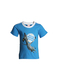

In [20]:
Image.open('/kaggle/input/fashion-product-images-small/images/'+image_urls[45])

In [21]:
def find_most_similar_vectors(query_vector, vector_list):
    similarities = []
    
    # Move query_vector to CPU if it's on a CUDA device
    if query_vector.is_cuda:
        query_vector = query_vector.cpu()
    
    # Calculate cosine similarity with each vector in the list
    for vector in vector_list:
        # Move vector to CPU if it's on a CUDA device
        if vector.is_cuda:
            vector = vector.cpu()
        
        similarity = torch.dot(query_vector, vector) / (torch.norm(query_vector) * torch.norm(vector))
        similarities.append(similarity.item())  # Convert tensor scalar to Python float
    
    # Sort the indices based on similarity and get the top 6
    top_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:20]
    
    return top_indices

In [22]:
top_i = find_most_similar_vectors(image_output[45], text_features)

In [23]:
top_i

[2449,
 2564,
 2031,
 2994,
 2655,
 2909,
 466,
 980,
 1401,
 1084,
 2644,
 1801,
 1497,
 2615,
 2697,
 1886,
 1917,
 1177,
 1302,
 2176]

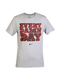

In [28]:
Image.open('/kaggle/input/fashion-product-images-small/images/'+image_urls[2449])

In [25]:
df.iloc[900]

id                                                                50175
gender                                                            Women
masterCategory                                                 Footwear
subCategory                                                       Shoes
articleType                                                       Flats
baseColour                                                        Black
season                                                           Winter
year                                                               2012
usage                                                            Casual
productDisplayName                      Rocia Women Black & Brown Flats
image                                                         50175.jpg
tags                  MasterCategory:'Footwear' SubCategory:'Shoes' ...
Name: 900, dtype: object

In [26]:
df.iloc[45]

id                                                                37623
gender                                                             Boys
masterCategory                                                  Apparel
subCategory                                                     Topwear
articleType                                                     Tshirts
baseColour                                                         Blue
season                                                           Summer
year                                                               2012
usage                                                            Casual
productDisplayName               Madagascar 3 Boys Blue Printed T-shirt
image                                                         37623.jpg
tags                  MasterCategory:'Apparel' SubCategory:'Topwear'...
Name: 45, dtype: object